# Predicting attendance on football matches in Poland

Notebook my Michal Maculewicz

### Table of contents:
**[1. Introduction](#intro)**  
**[2. Required libraries](#lib)**  
**[3. Data collection](#collect)**
* [3.1. Attendance and match results](#90min)
* [3.2. League tables](#transfermarkt)    
* [3.3. Stadiums' information](#wiki)  

**[4. Data preprocessing](#preproc)**  
* [4.1. Attendance and match results](#results)
* [4.2. League tables](#Table)
* [4.3. Stadiums' information](#stadium)
* [4.4. Feature extraction](#feature)  
* [4.5. Add weather data](#weather)
* [4.6. Missing values, outliers, encoding](#preparation)

**[5. Learning model](#model)**
* [5.1. Training the model](#train)
* [5.2. Plots creation](#plots)

**[6. Analysis](#res)** 


## Introduction <a class="anchor" id="intro"></a>

The idea behind this project is to build a **machine learning model** that would predict the number of attendees of polish ***Ekstraklasa*** (1st division) foootball matches as accurately as possible. It is important to mention, that unlike in *Bundesliga* or *Premier League*, polish stadiums are rarely completely filled. This in turn, creates the possibility to invstigate what lures people into buying tickets and what discourages them from doing so. The considered timespan begins with the start of 2013/14 season, when there was a major change in the league structure (final rounds were introduced and number of matches has increased) and ends with the Coronavirus outbreak in February 2020. This is an **end-to-end** project, that includes **data gathering** through web-scraping and external API, **data cleaning, transforming** and **modelling**. In result, a **Lasso Regression** model with a mean absolute error of under 2,500 has been developed. This means, that the **error got halved** over the method  of guessing using the mean value.


<br>

## Required libraries <a class="anchor" id="lib"></a>

Full list of libraries used in this project:
- pandas
- numpy
- requests
- Beautifulsoup
- re
- tqdm
- seaborn
- matplotlib
- sklearn
- pandasql
- datetime
- trans
- wwo_hist

Let's import them all at once and set some options.

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import requests
from bs4 import BeautifulSoup
import datetime
from trans import trans
from wwo_hist import retrieve_hist_data
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

<br>

## Data collection <a class="anchor" id="collect"></a>

In this section of the notebook data required in the project will be collected using web-scraping.

### Attendance and match results <a class="anchor" id="90min"></a>

Here, data on the attendance on each of the matches considered in the project, as well as the results of those games is obtained. We'll web-scrape one of the most popular polish football-related sites - **[90minut.pl](http://www.90minut.pl)**.  
  
Let's start with specifying the URLs for the seasons included in the project (13/14 - 19/20). It has to be done manualy as the URLs do not follow any pattern:

In [2]:
URL = ['http://www.90minut.pl/liga/1/liga10549.html',
       'http://www.90minut.pl/liga/0/liga9937.html',
       'http://www.90minut.pl/liga/0/liga9322.html',
       'http://www.90minut.pl/liga/0/liga8694.html',
       'http://www.90minut.pl/liga/0/liga8069.html',
       'http://www.90minut.pl/liga/0/liga7466.html',
       'http://www.90minut.pl/liga/0/liga6826.html'
      ]

<br>
Next code block iterates through URLs/seasons, scrapes them and creates a DataFrame containing all data.
<br>
<br>

In [3]:
results = pd.DataFrame()

for idx,url in enumerate(tqdm(URL)):
    
    #Create the Soup and select desired tables

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    tab = soup.find_all("table", attrs={"class": "main"})
    tab1 = soup.find_all('table', attrs={'class': 'main2'})
    
    
    # Extract the data from HTML tables and store them in DataFrame.

    for i in range(0, 73, 2):
        tab_rows = tab[i+1].find_all('tr')

        l = []
        for tr in tab_rows:
            td = tr.find_all('td')
            row = [j.text for j in td]
            l.append(row)
            
        df = pd.DataFrame(l)
        

        # Remove redundant rows (those with 'None' in last column which is attendance).
        # Extract and add to df a round ID.
        # Combine dfs into single object.

        res = df[~df[3].isnull()]
        res = res.reset_index(drop=True)
        res['round'] = re.findall(r'\d+', tab[i].tr.td.b.u.text)[0]

        if i == 0:
            result = res
        else:
            result = result.append(res, ignore_index=True)
            

    # Extract and add season ID to df.
    # Combine separate dfs into single DataFrame - results       
    
    result['season'] = tab1[0].tr.td.b.text
    
    results = results.append(result, ignore_index=True)

In [4]:
results.head()

,0,1,2,3,round,season
0,Arka Gdynia,0-3\n,Jagiellonia Białystok,"19 lipca, 18:00 (10 101)",1,PKO Ekstraklasa 2019/2020
1,Legia Warszawa,1-2\n,Pogoń Szczecin,"21 lipca, 17:30 (13 285)",1,PKO Ekstraklasa 2019/2020
2,ŁKS Łódź,0-0\n,Lechia Gdańsk,"19 lipca, 20:30 (5452)",1,PKO Ekstraklasa 2019/2020
3,Piast Gliwice,1-1\n,Lech Poznań,"20 lipca, 20:00 (4698)",1,PKO Ekstraklasa 2019/2020
4,Raków Częstochowa,0-1\n,Korona Kielce,"20 lipca, 15:00 (3365)",1,PKO Ekstraklasa 2019/2020


In [5]:
results.to_pickle('data/results_dirty.pkl')

<br>

### League tables <a class="anchor" id="transfermarkt"></a>

Another piece of information important in this project are the teams' past performances prior to each of the matches. For this reason we need complete league tables after each round/matchday. Website that allows to browse such tables relatively easily is worldwidely known **[transfermarkt.com](https://www.transfermarkt.com)**.

First thing to do is to obtain the table headers indicating what the columns represent.

In [6]:
URL = 'https://www.transfermarkt.com/ekstraklasa/formtabelle/wettbewerb/PL1?saison_id=2018&min=1&max=1'
headers = {"User-Agent":"Mozilla/5.0"}
response = requests.get(URL, headers=headers)
soup = BeautifulSoup(response.text, 'lxml')

tab = soup.find_all("div", attrs={"class": "responsive-table"})
tab_header = tab[0].table.thead.tr.find_all('th')
header = [i.text for i in tab_header]
header[2] = 'games'
header = header[:9]
print(header)

['#', 'Club', 'games', 'W', 'D', 'L', 'Goals', '+/-', 'Pts']


<br>
Next code block iterates through URLs/seasons and 37 rounds within each of them, scrapes the data and creates a DataFrame containing all information.
<br>
<br>

In [7]:
table = pd.DataFrame()

for idx, season in enumerate(tqdm(range(2013, 2020))):    
    
    for i in tqdm(range(1, 38)):
        
        #Create the Soup and select desired tables 
        
        URL = 'https://www.transfermarkt.pl/ekstraklasa/formtabelle/wettbewerb/PL1?saison_id='+str(season)+'&min=1&max='+str(i)
        response = requests.get(URL, headers=headers)
        soup = BeautifulSoup(response.text, 'lxml')
        tab = soup.find_all("div", attrs={"class": "responsive-table"})
        
        # Extract the data from HTML tables and store them in DataFrame.
        
        tab_rows = tab[0].table.tbody.find_all('tr')

        l = []
        for tr in tab_rows:
            td = tr.find_all('td')
            row = [j.text for j in td]
            l.append(row)

        df = pd.DataFrame(l)
        
        # Number of columns is not equal for all of the tables as some have an addtitional column indicating form which is
        # of no use at the moment. Similarly we don't need the second col which is empty. Let's remove the redundant ones.

        if len(df.columns) > 10:
            df = df.drop([1, 10], axis=1)
        else:
            df = df.drop([1], axis=1)

        df.columns = header
    
        # Tables are divided into two parts (places 1-8 and 9-16) on the website what makes them two separate tables, 
        # so the next step is similar to the one above.
    
        tab_rows = tab[1].table.tbody.find_all('tr')

        l = []
        for tr in tab_rows:
            td = tr.find_all('td')
            row = [j.text for j in td]
            l.append(row)

        df1 = pd.DataFrame(l)

        if len(df1.columns) > 10:
            df1 = df1.drop([1, 10], axis=1)
        else:
            df1 = df1.drop([1], axis=1)

        df1.columns = header
    
        # Combine two tables, apply the correct order, add round ID and append to previously created.
    
        df = df.append(df1, ignore_index=True)
        df = df.sort_values(['Pts', '+/-'], ascending=False)
        df['#'] = range(1, 17)
        df['round'] = i

        if i == 1:
            tabl = df
        else:
            tabl = tabl.append(df, ignore_index=True)
   
    # Add season ID and merge into one DataFrame - table

    tabl['season'] = str(season)+'/'+str(season+1)

    table = table.append(tabl, ignore_index=True)

In [8]:
table.head()

,#,Club,games,W,D,L,Goals,+/-,Pts,round,season
0,1,\nLegia Warszawa,1,1,0,0,5:1,4,3,1,2013/2014
1,2,\nPogoń Szczecin,1,1,0,0,2:0,2,3,1,2013/2014
2,3,\nPiast Gliwice,1,1,0,0,3:2,1,3,1,2013/2014
3,4,\nJagiellonia,1,1,0,0,1:0,1,3,1,2013/2014
4,5,\nLechia Gdańsk,1,0,1,0,2:2,0,1,1,2013/2014


In [9]:
table.to_pickle('data/table_dirty.pkl')

<br>

### Stadiums' information <a class="anchor" id="wiki"></a>

We also need the data on the stadiums, that matches took place on. That includes capacity and some potentially important annotations (e.g. stadium under construction, capacity varied across the season). Fortunately, **[Wikipedia](https://pl.wikipedia.org/)** serves as a perfect source of this information.

Let's start with obtaining the header of tables to be scraped.

In [10]:
URL = 'https://pl.wikipedia.org/wiki/Ekstraklasa_w_pi%C5%82ce_no%C5%BCnej_(2018/2019)'
response = requests.get(URL)
soup = BeautifulSoup(response.text, 'lxml')

# As the wanted table has no unique id we'll find it by it's header - Stadiony

for header in soup.find_all('h2'):
    if header.get_text().startswith('Stadiony'):
        tab = header.find_next_sibling()
        
tab_header = tab.tbody.tr.find_all('th')
header = [i.text for i in tab_header]
print(header)

['\n', 'Miejscowość\n', 'Stadion\n', 'Klub\n', 'Pojemność\n', 'Zdjęcie\n']


<br>
Next code block iterates through URLs/seasons, scrapes the data and creates a DataFrame containing all information.
<br>
<br>

In [11]:
stadiums = pd.DataFrame()

for idx, season in enumerate(tqdm(range(2013, 2020))):
        
        #Create the Soup and select desired tables
        
        URL = 'https://pl.wikipedia.org/wiki/Ekstraklasa_w_pi%C5%82ce_no%C5%BCnej_(' + str(season) + '/' + str(season+1) + ')'
        response = requests.get(URL)
        soup = BeautifulSoup(response.text, 'lxml')
       
        for head in soup.find_all('h2'):
            if head.get_text().startswith('Stadiony'):
                tab = head.find_next_sibling()
                
        # Extract the data from HTML tables and store them in DataFrame.
    
        tab_rows = tab.tbody.find_all('tr')

        l = []
        for tr in tab_rows:
            td = tr.find_all('td')
            row = [j.text for j in td]
            l.append(row)

        df = pd.DataFrame(l)
        
        # Remove first, empty row. Apply header as column names, add season ID and merge into one DataFrame - stadiums
        
        df = df.iloc[1:, :]
        df.columns = header
        df['season'] = str(season) + '/' + str(season+1)
        
        stadiums = stadiums.append(df, ignore_index=True)

In [12]:
stadiums.head()

,\n,Miejscowość\n,Stadion\n,Klub\n,Pojemność\n,Zdjęcie\n,season
0,\n,Wrocław\n,Stadion Wrocław\n,Śląsk Wrocław\n,42 771\n,\n,2013/2014
1,\n,Gdańsk\n,PGE Arena Gdańsk\n,Lechia Gdańsk\n,42 105\n,\n,2013/2014
2,\n,Poznań\n,INEA Stadion\n,Lech Poznań\n,41 609\n,\n,2013/2014
3,\n,Kraków\n,Stadion Miejski im. Henryka Reymana\n,Wisła Kraków\n,33 130\n,\n,2013/2014
4,\n,Warszawa\n,Stadion Wojska Polskiego w Warszawie\n,Legia Warszawa\n,31 103\n,\n,2013/2014


In [13]:
stadiums.to_pickle('data/stadiums_dirty.pkl')

<br>

## Data preprocessing <a class="anchor" id="preproc"></a>

In this section of the notebook data obtained previously is going to be cleaned into usable format. Additionaly, some potentially relevant features will be extracted and also weather data will be added.

### Attendance and match results <a class="anchor" id="results"></a>

First of all, we'll take care of cleaning the **results** df, the core of this project.

In [14]:
results = pd.read_pickle('data/results_dirty.pkl')

In [15]:
# Rename columns
results = results.rename(columns={0: 'home_team', 1: 'hg', 2: 'away_team', 3:'date_attendance'})

results.head()

,home_team,hg,away_team,date_attendance,round,season
0,Arka Gdynia,0-3\n,Jagiellonia Białystok,"19 lipca, 18:00 (10 101)",1,PKO Ekstraklasa 2019/2020
1,Legia Warszawa,1-2\n,Pogoń Szczecin,"21 lipca, 17:30 (13 285)",1,PKO Ekstraklasa 2019/2020
2,ŁKS Łódź,0-0\n,Lechia Gdańsk,"19 lipca, 20:30 (5452)",1,PKO Ekstraklasa 2019/2020
3,Piast Gliwice,1-1\n,Lech Poznań,"20 lipca, 20:00 (4698)",1,PKO Ekstraklasa 2019/2020
4,Raków Częstochowa,0-1\n,Korona Kielce,"20 lipca, 15:00 (3365)",1,PKO Ekstraklasa 2019/2020


In [16]:
# Remove whitespaces from home_team and away_team columns
results[['home_team', 'away_team']] = results[['home_team', 'away_team']].applymap(lambda x: x[2:-2])

# Team 'Cracovia Kraków' has its city missing in the dataset, let's add it
results[['home_team', 'away_team']] = \
results[['home_team', 'away_team']].applymap(lambda x: " ".join([x, 'Kraków']) if x=='Cracovia' else x)

# Remove new line marker
results['hg'] = [score[:-1] for score in results['hg'] if score.endswith('\n')]

# Column with score will be divided into two separate columns: home goals and away goals. Thus, let's insert new empty column
results.insert(2, 'ag', np.nan) 

# Split the column with score into two separate for home and away goals
results[['hg', 'ag']] = results['hg'].str.split('-', expand=True) 

# Check whether changes were applied correctly
results.head()

,home_team,hg,ag,away_team,date_attendance,round,season
0,Arka Gdynia,0,3,Jagiellonia Białystok,"19 lipca, 18:00 (10 101)",1,PKO Ekstraklasa 2019/2020
1,Legia Warszawa,1,2,Pogoń Szczecin,"21 lipca, 17:30 (13 285)",1,PKO Ekstraklasa 2019/2020
2,ŁKS Łódź,0,0,Lechia Gdańsk,"19 lipca, 20:30 (5452)",1,PKO Ekstraklasa 2019/2020
3,Piast Gliwice,1,1,Lech Poznań,"20 lipca, 20:00 (4698)",1,PKO Ekstraklasa 2019/2020
4,Raków Częstochowa,0,1,Korona Kielce,"20 lipca, 15:00 (3365)",1,PKO Ekstraklasa 2019/2020


In [17]:
# Extract attendance from parenthesis, remove whitespace (thousand separator), fill nans with 0 and convert to int
results['attendance'] = results['date_attendance'].str.extract('\(([^\)]+)\)')[0].str.replace(' ', '').fillna(0).astype('int')

# Create day, month and hour columns from date_attendance 
results['day'] = results['date_attendance'].str.split(' ', expand=True)[0] #create day column
results['month'] = results['date_attendance'].str.split(' ', expand=True)[1] #create month column
results['hour'] = results['date_attendance'].str.split(' ', expand=True)[2] #add hour coolumn

# Remove the comma from the end of month names
results['month'] = results['month'].str[:-1] 

# Drop column
results = results.drop(['date_attendance'], axis='columns')

# Review the applied changes
results.head()

,home_team,hg,ag,away_team,round,season,attendance,day,month,hour
0,Arka Gdynia,0,3,Jagiellonia Białystok,1,PKO Ekstraklasa 2019/2020,10101,19,lipca,18:00
1,Legia Warszawa,1,2,Pogoń Szczecin,1,PKO Ekstraklasa 2019/2020,13285,21,lipca,17:30
2,ŁKS Łódź,0,0,Lechia Gdańsk,1,PKO Ekstraklasa 2019/2020,5452,19,lipca,20:30
3,Piast Gliwice,1,1,Lech Poznań,1,PKO Ekstraklasa 2019/2020,4698,20,lipca,20:00
4,Raków Częstochowa,0,1,Korona Kielce,1,PKO Ekstraklasa 2019/2020,3365,20,lipca,15:00


In [18]:
# Create and apply a function to convert the months from polish names to number
def month_conv(x):
    if x.startswith('sty'):
        return 1
    elif x.startswith('lut'):
        return 2
    elif x.startswith('mar'):
        return 3
    elif x.startswith('kwi'):
        return 4
    elif x.startswith('maj'):
        return 5
    elif x.startswith('cze'):
        return 6
    elif x.startswith('lip'):
        return 7
    elif x.startswith('sie'):
        return 8
    elif x.startswith('wrz'):
        return 9
    elif x.startswith('paź'):
        return 10
    elif x.startswith('lis'):
        return 11
    elif x.startswith('gru'):
        return 12
    
results['month'] = results['month'].apply(month_conv)
results.head()

,home_team,hg,ag,away_team,round,season,attendance,day,month,hour
0,Arka Gdynia,0,3,Jagiellonia Białystok,1,PKO Ekstraklasa 2019/2020,10101,19,7,18:00
1,Legia Warszawa,1,2,Pogoń Szczecin,1,PKO Ekstraklasa 2019/2020,13285,21,7,17:30
2,ŁKS Łódź,0,0,Lechia Gdańsk,1,PKO Ekstraklasa 2019/2020,5452,19,7,20:30
3,Piast Gliwice,1,1,Lech Poznań,1,PKO Ekstraklasa 2019/2020,4698,20,7,20:00
4,Raków Częstochowa,0,1,Korona Kielce,1,PKO Ekstraklasa 2019/2020,3365,20,7,15:00


In [19]:
# Leave only years in season column
results['season'] = results['season'].str[-9:]

# Year was missing in the dates of matches, so it has to be extracted other way. As new season always starts in July,
# the function below assigns the year before the slash sign to matches played after June and the year after the slash to those
# played in 1st half of the year

def get_year(row): 
    if row['month'] > 6:
        return(row['season'][-9:-5])
    else:
        return(row['season'][-4:])
    
results['year'] = results.apply(get_year, axis=1)
results.head()

,home_team,hg,ag,away_team,round,season,attendance,day,month,hour,year
0,Arka Gdynia,0,3,Jagiellonia Białystok,1,2019/2020,10101,19,7,18:00,2019
1,Legia Warszawa,1,2,Pogoń Szczecin,1,2019/2020,13285,21,7,17:30,2019
2,ŁKS Łódź,0,0,Lechia Gdańsk,1,2019/2020,5452,19,7,20:30,2019
3,Piast Gliwice,1,1,Lech Poznań,1,2019/2020,4698,20,7,20:00,2019
4,Raków Częstochowa,0,1,Korona Kielce,1,2019/2020,3365,20,7,15:00,2019


In [20]:
# Sort columns in desired order
results = results[['home_team', 'hg', 'ag', 'away_team', 'day', 'month', 'year', 'hour', 'season', 'round', 'attendance']]

In [21]:
# Print unique values in each of columns to check if there are any issues
for col in results.columns:
    print(col, pd.unique(results[col]))

home_team ['Arka Gdynia' 'Legia Warszawa' 'ŁKS Łódź' 'Piast Gliwice'
 'Raków Częstochowa' 'Wisła Kraków' 'Wisła Płock' 'Zagłębie Lubin'
 'Cracovia Kraków' 'Górnik Zabrze' 'Jagiellonia Białystok' 'Korona Kielce'
 'Lech Poznań' 'Lechia Gdańsk' 'Pogoń Szczecin' 'Śląsk Wrocław'
 'Miedź Legnica' 'Zagłębie Sosnowiec' 'Bruk-Bet Termalica Nieciecza'
 'Sandecja Nowy Sącz' 'Ruch Chorzów' 'Górnik Łęczna'
 'Podbeskidzie Bielsko-Biała' 'Termalica Bruk-Bet Nieciecza'
 'Zawisza Bydgoszcz' 'GKS Bełchatów' 'Widzew Łódź']
hg ['0' '1' '4' '2' '3' '5' '7' '6' 'x']
ag ['3' '2' '0' '1' '4' '5' '6' 'x']
away_team ['Jagiellonia Białystok' 'Pogoń Szczecin' 'Lechia Gdańsk' 'Lech Poznań'
 'Korona Kielce' 'Śląsk Wrocław' 'Górnik Zabrze' 'Cracovia Kraków'
 'ŁKS Łódź' 'Zagłębie Lubin' 'Raków Częstochowa' 'Legia Warszawa'
 'Wisła Płock' 'Wisła Kraków' 'Arka Gdynia' 'Piast Gliwice'
 'Miedź Legnica' 'Zagłębie Sosnowiec' 'Sandecja Nowy Sącz'
 'Bruk-Bet Termalica Nieciecza' 'Górnik Łęczna' 'Ruch Chorzów'
 'Podbeskidzie 

In [22]:
# In hg and ag columns there is one 'x' instead of only numbers. It is because this match has been cancelled. Remove it.
results = results[~(results['hg'] == 'x')]


# One club has two different names: Bruk-Bet Termalica Nieciecza and Termalica Bruk-Bet Nieczecza.
# Change those to Termalica Nieciecza
results.loc[(results['home_team'] == 'Bruk-Bet Termalica Nieciecza') |\
        (results['home_team'] == 'Termalica Bruk-Bet Nieciecza'), 'home_team'] = 'Termalica Nieciecza'

results.loc[(results['away_team'] == 'Bruk-Bet Termalica Nieciecza') |\
        (results['away_team'] == 'Termalica Bruk-Bet Nieciecza'), 'away_team'] = 'Termalica Nieciecza'

# Change the column types to int
results[['hg', 'ag', 'day', 'year', 'round']] = results[['hg', 'ag', 'day', 'year', 'round']].astype('int')

# Remove matches after the coronavirus outbreak
results = results[~(results['year'] == 2020) | (results['round'] < 27)]
results = results.reset_index(drop=True)

results

,home_team,hg,ag,away_team,day,month,year,hour,season,round,attendance
0,Arka Gdynia,0,3,Jagiellonia Białystok,19,7,2019,18:00,2019/2020,1,10101
1,Legia Warszawa,1,2,Pogoń Szczecin,21,7,2019,17:30,2019/2020,1,13285
2,ŁKS Łódź,0,0,Lechia Gdańsk,19,7,2019,20:30,2019/2020,1,5452
3,Piast Gliwice,1,1,Lech Poznań,20,7,2019,20:00,2019/2020,1,4698
4,Raków Częstochowa,0,1,Korona Kielce,20,7,2019,15:00,2019/2020,1,3365
...,...,...,...,...,...,...,...,...,...,...,...
2011,Górnik Zabrze,0,2,Lechia Gdańsk,1,6,2014,18:00,2013/2014,37,3000
2012,Cracovia Kraków,2,2,Jagiellonia Białystok,31,5,2014,20:30,2013/2014,37,6021
2013,Korona Kielce,1,5,Śląsk Wrocław,31,5,2014,20:30,2013/2014,37,6475
2014,Piast Gliwice,2,2,Podbeskidzie Bielsko-Biała,31,5,2014,20:30,2013/2014,37,5953


<br>

Lastly, let's run some **tests** to check if conditions are met and see if there are any missing values.
<br>
<br>

In [23]:
assert len(results['home_team'].unique()) == len(results['away_team'].unique())
assert results['day'].isin(range(1,32)).all()
assert results['month'].isin(range(1,13)).all()
assert results['year'].isin(range(2013,2021)).all()
assert results['round'].isin(range(1,38)).all()

print('There are {} missing values.'.format(results.isnull().sum().sum()))

There are 0 missing values.


In [24]:
results.to_pickle('data/results_clean.pkl')

<br> 

### League tables <a class="anchor" id="Table"></a>

Next, **table** df will be cleaned.

In [25]:
table = pd.read_pickle('data/table_dirty.pkl')
table.head()

,#,Club,games,W,D,L,Goals,+/-,Pts,round,season
0,1,\nLegia Warszawa,1,1,0,0,5:1,4,3,1,2013/2014
1,2,\nPogoń Szczecin,1,1,0,0,2:0,2,3,1,2013/2014
2,3,\nPiast Gliwice,1,1,0,0,3:2,1,3,1,2013/2014
3,4,\nJagiellonia,1,1,0,0,1:0,1,3,1,2013/2014
4,5,\nLechia Gdańsk,1,0,1,0,2:2,0,1,1,2013/2014


In [26]:
# Remove \n from beginning of club names
table['Club'] = table['Club'].str[1:] 

# Remove \xa0 and whitespaces from end of club names
table['Club'] = table['Club'].str.rstrip('\xa0 ') 

# Change the 'Z. Sosnowiec' into full name - 'Zagłębie Sosnowiec'
table.loc[table['Club'].str.startswith('Z.'), 'Club'] = 'Zagłębie Sosnowiec' 



<br>

There is a need of **unifying** the club names as they do vary between sources. The form present in the **results** df is the preferred one.
<br>
<br>

In [27]:
table_clubs = sorted(table['Club'].unique())
results_clubs = sorted(results['home_team'].unique())

# Retreive club names that need to be changed in table df
wrong_names = [club for club in table_clubs if club not in results_clubs]
print('Wrong names:', wrong_names)

# Wrong names contain only part of full name. Create pairs of the correct and wrong form of the club name.
tobe_changed = [(correct, wrong) for correct in results_clubs for wrong in wrong_names if wrong in correct]
print('List of changes:', tobe_changed)

# Apply changes
for club in tobe_changed:
    table.loc[table['Club'] == club[1], 'Club'] = club[0]

Wrong names: ['Cracovia', 'Jagiellonia', 'Podbeskidzie', 'Raków', 'Sandecja', 'Termalica', 'Zawisza']
List of changes: [('Cracovia Kraków', 'Cracovia'), ('Jagiellonia Białystok', 'Jagiellonia'), ('Podbeskidzie Bielsko-Biała', 'Podbeskidzie'), ('Raków Częstochowa', 'Raków'), ('Sandecja Nowy Sącz', 'Sandecja'), ('Termalica Nieciecza', 'Termalica'), ('Zawisza Bydgoszcz', 'Zawisza')]


In [28]:
# Column with goals will be divided into two separate columns: goals for and goals against. Thus, let's insert new empty column
table.insert(7, 'goals_against', np.nan) 

# Split the column with score into two separate for home and away goals
table[['Goals', 'goals_against']] = table['Goals'].str.split(':', expand=True)

# Rename columns
table.rename(columns={'Goals':'goals_for', '#':'position'}, inplace=True) 

table.head()

,position,Club,games,W,D,L,goals_for,goals_against,+/-,Pts,round,season
0,1,Legia Warszawa,1,1,0,0,5,1,4,3,1,2013/2014
1,2,Pogoń Szczecin,1,1,0,0,2,0,2,3,1,2013/2014
2,3,Piast Gliwice,1,1,0,0,3,2,1,3,1,2013/2014
3,4,Jagiellonia Białystok,1,1,0,0,1,0,1,3,1,2013/2014
4,5,Lechia Gdańsk,1,0,1,0,2,2,0,1,1,2013/2014


In [29]:
# Convert col types to int where applicable
table[['position', 'games', 'W', 'D', 'L', 'goals_for', 'goals_against', '+/-', 'Pts']] = \
table[['position', 'games', 'W', 'D', 'L', 'goals_for', 'goals_against', '+/-', 'Pts']].astype('int')

<br>

Lastly, let's run some **tests** to check if conditions are met and see if there are any missing values.
<br>
<br>

In [30]:
assert len(table['Club'].unique()) == len(results['home_team'].unique()) == len(results['away_team'].unique())
assert table['position'].isin(range(1,17)).all()
assert table[['games', 'W', 'D', 'L', 'round']].isin(range(0,38)).all().all()

print('There are {} missing values.'.format(table.isnull().sum().sum()))

There are 0 missing values.


In [31]:
table.to_pickle('data/table_clean.pkl')

<br>

### Stadiums' infromation <a class="anchor" id="stadium"></a>

In this part we're going to tidy the **stadium** df and join it to **results** df.

In [32]:
stadiums = pd.read_pickle('data/stadiums_dirty.pkl')
stadiums.head()

,\n,Miejscowość\n,Stadion\n,Klub\n,Pojemność\n,Zdjęcie\n,season
0,\n,Wrocław\n,Stadion Wrocław\n,Śląsk Wrocław\n,42 771\n,\n,2013/2014
1,\n,Gdańsk\n,PGE Arena Gdańsk\n,Lechia Gdańsk\n,42 105\n,\n,2013/2014
2,\n,Poznań\n,INEA Stadion\n,Lech Poznań\n,41 609\n,\n,2013/2014
3,\n,Kraków\n,Stadion Miejski im. Henryka Reymana\n,Wisła Kraków\n,33 130\n,\n,2013/2014
4,\n,Warszawa\n,Stadion Wojska Polskiego w Warszawie\n,Legia Warszawa\n,31 103\n,\n,2013/2014


In [33]:
# Remove new line marker
stadiums = stadiums.applymap(lambda x: x.rstrip('\n'))

# Do same with col names
stadiums.columns =  stadiums.columns.str.rstrip('\n')

# Remove redundant columns and rename remaining
stadiums = stadiums[['Miejscowość', 'Klub', 'Pojemność', 'season']]
stadiums = stadiums.rename(columns={'Miejscowość':'City', 'Klub':'Club', 'Pojemność':'Capacity'})

stadiums.head()

,City,Club,Capacity,season
0,Wrocław,Śląsk Wrocław,42 771,2013/2014
1,Gdańsk,Lechia Gdańsk,42 105,2013/2014
2,Poznań,Lech Poznań,41 609,2013/2014
3,Kraków,Wisła Kraków,33 130,2013/2014
4,Warszawa,Legia Warszawa,31 103,2013/2014


In [34]:
# Some observations were annotated in wikipedia with use of []. Let's save them to separate df and investigate them later,
# as there might be some information relevant for the purpose of this project. Also remove them from the original df.

stad_to_investigate = stadiums[(stadiums['Club'].str.endswith(']')) | (stadiums['Capacity'].str.endswith(']'))]
stadiums = stadiums.loc[~stadiums.index.isin(stad_to_investigate.index), :]
stadiums = stadiums.reset_index(drop=True)
stad_to_investigate = stad_to_investigate.reset_index(drop=True)

In [35]:
# Manually change wrong club names
stadiums.loc[stadiums['Club'] == 'Bruk-Bet Termalica Nieciecza', 'Club'] = 'Termalica Nieciecza'
stadiums.loc[stadiums['Club'] == 'Cracovia', 'Club'] = 'Cracovia Kraków'

In [36]:
# Remove the thousand separators: '\xa0' and whitespace
stadiums['Capacity'] = stadiums['Capacity'].str.replace('\xa0', '')
stadiums['Capacity'] = stadiums['Capacity'].str.replace(' ', '')

<br>

Let's merge the **results** and **stadiums** dfs
<br>
<br>

In [37]:
results = results.merge(stadiums, how='left', left_on=['home_team', 'season'], right_on=['Club', 'season'])
results = results.drop('Club', axis=1)
results.head()

,home_team,hg,ag,away_team,day,month,year,hour,season,round,attendance,City,Capacity
0,Arka Gdynia,0,3,Jagiellonia Białystok,19,7,2019,18:00,2019/2020,1,10101,Gdynia,15139
1,Legia Warszawa,1,2,Pogoń Szczecin,21,7,2019,17:30,2019/2020,1,13285,Warszawa,31103
2,ŁKS Łódź,0,0,Lechia Gdańsk,19,7,2019,20:30,2019/2020,1,5452,Łódź,5700
3,Piast Gliwice,1,1,Lech Poznań,20,7,2019,20:00,2019/2020,1,4698,Gliwice,9913
4,Raków Częstochowa,0,1,Korona Kielce,20,7,2019,15:00,2019/2020,1,3365,Bełchatów,5264


<br>

Lastly, let's investigate the **annotations** mentioned before. Most of them relates to the stadium beeing under construction, so at the same time we'll add a column indicating such a situation.
<br>
<br>

In [38]:
# Information below has been manually verified on wikipedia pages

stad_to_investigate
# 0 - stadium under construction
# 1 - stadium under construction, max stadium capacity equals 3651
# 2 - stadium under construction
# 3 - stadium under construction, with given capacity was finished in october (before 12th round), before it had capacity of 7500
# 4 - 2nd leg match Ruch Chorzów vs Górnik Łęczna was played in Gliwice
# 5 - stadium under construction, before February 2015 maximum capacity equals 3404
# 6 - stadium under construction
# 7 - stadium under construction, until 10th round max capacity equals 5520. Then until 22nd leg - 8500 
# 8 - stadium under construction
# 9 - until 15th round Termalica played in Mielec
# 10 - starting from 16th leg
# 11 - Sandecja played in Nieciecza
# 12 - stadium under construction

,City,Club,Capacity,season
0,Białystok,Jagiellonia Białystok,7500[b],2013/2014
1,Bielsko-Biała,Podbeskidzie Bielsko-Biała,3404[c],2013/2014
2,Zabrze,Górnik Zabrze,3000[d],2013/2014
3,Białystok,Jagiellonia Białystok,22 386[ad],2014/2015
4,Gliwice,Piast GliwiceRuch Chorzów[ae],10 037,2014/2015
5,Bielsko-Biała,Podbeskidzie Bielsko-Biała,6962[af],2014/2015
6,Zabrze,Górnik Zabrze,3000[ag],2014/2015
7,Zabrze,Górnik Zabrze,24 413[d],2015/2016
8,Bielsko-Biała,Podbeskidzie Bielsko-Biała,6962[e],2015/2016
9,Mielec,Termalica Bruk-Bet Nieciecza[f],6864,2015/2016


In [39]:
# Insert the inConstruction column to results df and fill in the information gained manually.
results.insert(len(results.columns), 'inConstruction', 0) 

#0
results.loc[(results['home_team'] == 'Jagiellonia Białystok') & (results['season'] == '2013/2014'), ['City', 'Capacity', 'inConstruction']] = ['Białystok', 7500, 1]
#1 
results.loc[(results['home_team'] == 'Podbeskidzie Bielsko-Biała') & (results['season'] == '2013/2014'), ['City', 'Capacity', 'inConstruction']] = ['Bielsko-Biała', 3651, 1]
#2
results.loc[(results['home_team'] == 'Górnik Zabrze') & (results['season'] == '2013/2014'), ['City', 'Capacity', 'inConstruction']] = ['Zabrze', 3000, 1]
#3
results.loc[(results['home_team'] == 'Jagiellonia Białystok') & (results['season'] == '2014/2015') & (results['round'] < 12), ['City', 'Capacity', 'inConstruction']] = ['Białystok', 7500, 1]
results.loc[(results['home_team'] == 'Jagiellonia Białystok') & (results['season'] == '2014/2015') & (results['round'] >= 12), ['City', 'Capacity', 'inConstruction']] = ['Białystok', 22386, 1]
#4
results.loc[(results['home_team'] == 'Piast Gliwice') & (results['season'] == '2014/2015'), ['City', 'Capacity', 'inConstruction']] = ['Gliwice', 10037, 0]
results.loc[(results['home_team'] == 'Ruch Chorzów') & (results['season'] == '2014/2015') & (results['round'] == 2), ['City', 'Capacity', 'inConstruction']] = ['Gliwice', 10037, 0]
#5
results.loc[(results['home_team'] == 'Podbeskidzie Bielsko-Biała') & (results['season'] == '2014/2015') & (results['round'] < 20), ['City', 'Capacity', 'inConstruction']] = ['Bielsko-Biała', 3404, 1]
results.loc[(results['home_team'] == 'Podbeskidzie Bielsko-Biała') & (results['season'] == '2014/2015') & (results['round'] > 20), ['City', 'Capacity', 'inConstruction']] = ['Bielsko-Biała', 6962, 1]
#6
results.loc[(results['home_team'] == 'Górnik Zabrze') & (results['season'] == '2014/2015'), ['City', 'Capacity', 'inConstruction']] = ['Zabrze', 3000, 1]
#7
results.loc[(results['home_team'] == 'Górnik Zabrze') & (results['season'] == '2015/2016') & (results['round'] <= 10), ['City', 'Capacity', 'inConstruction']] = ['Zabrze', 5520, 1]
results.loc[(results['home_team'] == 'Górnik Zabrze') & (results['season'] == '2015/2016') & (results['round'] > 10) & (results['round'] <= 22), ['City', 'Capacity', 'inConstruction']] = ['Zabrze', 8500, 1]
results.loc[(results['home_team'] == 'Górnik Zabrze') & (results['season'] == '2015/2016') & (results['round'] > 22), ['City', 'Capacity', 'inConstruction']] = ['Zabrze', 24413, 1]
#8
results.loc[(results['home_team'] == 'Podbeskidzie Bielsko-Biała') & (results['season'] == '2015/2016'), ['City', 'Capacity', 'inConstruction']] = ['Bielsko-Biała', 6962, 1]
#9
results.loc[(results['home_team'] == 'Termalica Nieciecza') & (results['season'] == '2015/2016') & (results['round'] <= 15), ['City', 'Capacity', 'inConstruction']] = ['Mielec', 6864, 0]
#10
results.loc[(results['home_team'] == 'Termalica Nieciecza') & (results['season'] == '2015/2016') & (results['round'] > 15), ['City', 'Capacity', 'inConstruction']] = ['Nieciecza', 4600, 0]
#11
results.loc[(results['home_team'] == 'Termalica Nieciecza') & (results['season'] == '2017/2018'), ['City', 'Capacity', 'inConstruction']] = ['Nieciecza', 4666, 0]
results.loc[(results['home_team'] == 'Sandecja Nowy Sącz') & (results['season'] == '2017/2018'), ['City', 'Capacity', 'inConstruction']] = ['Nieciecza', 4666, 0]
#12
results.loc[(results['home_team'] == 'Pogoń Szczecin') & (results['season'] == '2019/2020'), ['City', 'Capacity', 'inConstruction']] = ['Szczecin', 4197, 1]

In [40]:
# Convert capacity to int
results['Capacity'] = results['Capacity'].astype('int')

In [41]:
# Check if there is any missing data in columns joined
assert ~results[['City', 'Capacity', 'inConstruction']].isnull().any().any()

<br>

### Feature extraction <a class="anchor" id="feature"></a>

Now it's time to supply the **results** df with features indicating teams' past performance - potential predictors in modelling part.

Firstly, the **results** df will be joined togetger with **table** multiple times in order to assign various information from **table** df to any particular match from **results** df. It will be done via **sql queries**. As the *pandasql* library uses the term 'table' internally what causes errors, name of the df is changed to **tablee**.

In [42]:
tablee = table
tablee = tablee.rename(columns={'+/-':'goal_diff'})

In [43]:
# Add the rank of the home_team in table when match took place
q = """SELECT
        r.*, t.position as rank
     FROM
        results r
     LEFT JOIN
        tablee t
           ON r.round = (t.round+1) AND r.home_team = t.Club AND r.season = t.season;"""

results = pysqldf(q)

In [44]:
# Add the rank of the away_team in table when match took place
q = """SELECT
        r.*, t.position as rank_opp
     FROM
        results r
     LEFT JOIN
        tablee t
           ON r.round = (t.round+1) AND r.away_team = t.Club AND r.season = t.season;"""

results = pysqldf(q)

In [45]:
# Add the goal difference for the home_team prior to the match
q = """SELECT
        r.*, t.goal_diff as goal_diff
     FROM
        results r
     LEFT JOIN
        tablee t
           ON r.round = (t.round+1) AND r.home_team = t.Club AND r.season = t.season;"""

results = pysqldf(q)

In [46]:
# Add points gained, goals scored and goal difference for the home_team in last 1-10 matches.
q = """SELECT
        r.*,
        (t.Pts - t1.Pts) as pts_l1m,
        (t.Pts - t2.Pts) as pts_l2m,
        (t.Pts - t3.Pts) as pts_l3m,
        (t.Pts - t4.Pts) as pts_l4m,
        (t.Pts - t5.Pts) as pts_l5m,
        (t.Pts - t6.Pts) as pts_l6m,
        (t.Pts - t7.Pts) as pts_l7m,
        (t.Pts - t8.Pts) as pts_l8m,
        (t.Pts - t9.Pts) as pts_l9m,
        (t.Pts - t10.Pts) as pts_l10m,
        (t.goals_for - t1.goals_for) as gs_l1m,
        (t.goals_for - t2.goals_for) as gs_l2m,
        (t.goals_for - t3.goals_for) as gs_l3m,
        (t.goals_for - t4.goals_for) as gs_l4m,
        (t.goals_for - t5.goals_for) as gs_l5m,
        (t.goals_for - t6.goals_for) as gs_l6m,
        (t.goals_for - t7.goals_for) as gs_l7m,
        (t.goals_for - t8.goals_for) as gs_l8m,
        (t.goals_for - t9.goals_for) as gs_l9m,
        (t.goals_for - t10.goals_for) as gs_l10m,
        (t.goal_diff - t1.goal_diff) as gd_l1m,
        (t.goal_diff - t2.goal_diff) as gd_l2m,
        (t.goal_diff - t3.goal_diff) as gd_l3m,
        (t.goal_diff - t4.goal_diff) as gd_l4m,
        (t.goal_diff - t5.goal_diff) as gd_l5m,
        (t.goal_diff - t6.goal_diff) as gd_l6m,
        (t.goal_diff - t7.goal_diff) as gd_l7m,
        (t.goal_diff - t8.goal_diff) as gd_l8m,
        (t.goal_diff - t9.goal_diff) as gd_l9m,
        (t.goal_diff - t10.goal_diff) as gd_l10m
     FROM
        results r
     LEFT JOIN
        tablee t
           ON r.round = (t.round+1) AND r.home_team = t.Club AND r.season = t.season
     LEFT JOIN
        tablee t1
           ON (t.round+1) = (t1.round+2) AND t.Club = t1.Club AND t.season = t1.season
     LEFT JOIN
        tablee t2
           ON (t.round+1) = (t2.round+3) AND t.Club = t2.Club AND t.season = t2.season
     LEFT JOIN
        tablee t3
           ON (t.round+1) = (t3.round+4) AND t.Club = t3.Club AND t.season = t3.season
     LEFT JOIN
        tablee t4
           ON (t.round+1) = (t4.round+5) AND t.Club = t4.Club AND t.season = t4.season
     LEFT JOIN
        tablee t5
           ON (t.round+1) = (t5.round+6) AND t.Club = t5.Club AND t.season = t5.season
     LEFT JOIN
        tablee t6
           ON (t.round+1) = (t6.round+7) AND t.Club = t6.Club AND t.season = t6.season      
     LEFT JOIN
        tablee t7
           ON (t.round+1) = (t7.round+8) AND t.Club = t7.Club AND t.season = t7.season
     LEFT JOIN
        tablee t8
           ON (t.round+1) = (t8.round+9) AND t.Club = t8.Club AND t.season = t8.season
     LEFT JOIN
        tablee t9
           ON (t.round+1) = (t9.round+10) AND t.Club = t9.Club AND t.season = t9.season      
     LEFT JOIN
        tablee t10
           ON (t.round+1) = (t10.round+11) AND t.Club = t10.Club AND t.season = t10.season;"""

results = pysqldf(q)

<br>

Now, that all available, valuable information has been retreived from the **tablee** df, we can focus on the **results** df itself.
<br>
<br>

In [47]:
# Add feature indicating the difference in ranks of away and home team.
results['rank_diff'] = results['rank_opp'] - results['rank']

In [48]:
# Create and apply a function to indicate whether the match was played in main season or during final round (last 7 rounds)
def fin_round(row):
    if row['round'] <= 30:
        return(0)
    else:
        return(1)

results['final_round'] = results.apply(fin_round, axis=1)

In [49]:
# Create and apply a function to check if the match was played in club's home town or somewhere else
def city_check(row):
    if row['home_team'].split(' ', 1)[1] == row['City']:
        return(1)
    else:
        return(0)

results['own_city'] = results.apply(city_check, axis=1)

In [50]:
# Create a date column in datetime format
results['date'] = pd.to_datetime(results[['year', 'month', 'day']])

# Retreive and add weekday
results['weekday'] =  results['date'].dt.day_name()

# Convert hour string into float with decimal places indicating part of full hour (18:30 -> 18.5)
results['hour_dec'] = [int(row.split(':')[0]) + int(row.split(':')[1])/60 for row in results['hour']] 

<br>

## Add weather data <a class="anchor" id="weather"></a>

In this section, the information about weather during and before the match is added to the dataset. It is done via [World weather online](https://www.worldweatheronline.com/) **API**.

**NOTE**: This API requests take considerable amount of time to complete. The number of daily requests is also limited (free trial account). Thus, the code block below is commented to show how the data has been obtained but not to be executed every time the script is run. Instead, after completing, the data has been saved into *pkl* file and will be imported further on.

In [51]:
# # Get min and max date of some match played by city
# city_dates = results.groupby('City', as_index=False)
# city_dates = city_dates['date'].agg(['min', 'max'])

# weather = pd.DataFrame()

# # Construct an API call with hourly frequency
# frequency=1
# api_key = MY_KEY


# for city in city_dates.index:
    
#     # Remove polish diacritics with use of trans library
#     location_list = [trans(city)]
    
#     start_date = city_dates.loc[city, 'min'].strftime('%d-%b-%Y')
#     end_date = city_dates.loc[city, 'max'].strftime('%d-%b-%Y')
    
#     data = retrieve_hist_data(api_key,
#                             location_list,
#                             start_date,
#                             end_date,
#                             frequency,
#                             location_label = False,
#                             export_csv = False,
#                             store_df = True)
    
#     weather = weather.append(data, ignore_index=True)

# # Select desired columns
# weather = weather[['date_time', 'cloudcover', 'precipMM', 'tempC', 'location']]
    
# weather.to_pickle('data/weather.pkl')

In [52]:
weather = pd.read_pickle('data/weather.pkl')
weather.head()

,date_time,cloudcover,precipMM,tempC,location
0,2014-07-25 00:00:00,100,0.0,16,Belchatow
1,2014-07-25 01:00:00,96,0.0,16,Belchatow
2,2014-07-25 02:00:00,91,0.5,16,Belchatow
3,2014-07-25 03:00:00,87,0.6,16,Belchatow
4,2014-07-25 04:00:00,91,0.3,17,Belchatow


In [53]:
# Create separate columns for date and hour
weather['date'] = weather['date_time'].dt.date
weather['hour'] = weather['date_time'].dt.strftime('%H:%M')

In [54]:
# Check the column dtypes
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944640 entries, 0 to 944639
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date_time   944640 non-null  datetime64[ns]
 1   cloudcover  944640 non-null  object        
 2   precipMM    944640 non-null  object        
 3   tempC       944640 non-null  object        
 4   location    944640 non-null  object        
 5   date        944640 non-null  object        
 6   hour        944640 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 50.4+ MB


In [55]:
# Convert numeric columns to float
weather[['cloudcover', 'precipMM', 'tempC']] = weather[['cloudcover', 'precipMM', 'tempC']].astype('float')

In [56]:
# Create columns indicating the 2h-12h rolling average for cloudcover and temperature. Also add the sum of precipitation in given periods.

for i in tqdm(np.arange(2, 13, 1)):
    
    weather[['cloudcover_avg' + str(i) + 'h', 'tempC_avg' + str(i) + 'h']] = \
    weather.groupby(['location', 'date'])[['cloudcover', 'tempC']].transform(lambda x: x.rolling(i, 1).mean().round(2))
    
    weather['precip_sum' + str(i) + 'h'] = weather.groupby(['location', 'date'])['precipMM'].transform(lambda x: x.rolling(i, 1).sum().round(2))

In [57]:
# Convert date to datetime format
weather['date'] = pd.to_datetime(weather['date'])

In [58]:
# Insert a column with hour without minutes for merging purposes
results['hour_floor'] = results['hour'].str[:2] + ':00'

# Remove polish diacritics form city names
results['City'] = results['City'].apply(lambda x: trans(x))

In [59]:
# Merge results with weather information
results = results.merge(weather, how='left', left_on=['City', 'date', 'hour_floor'], right_on=['location', 'date', 'hour'])
results.head()

,home_team,hg,ag,away_team,day,month,year,hour_x,season,round,...,precip_sum9h,cloudcover_avg10h,tempC_avg10h,precip_sum10h,cloudcover_avg11h,tempC_avg11h,precip_sum11h,cloudcover_avg12h,tempC_avg12h,precip_sum12h
0,Arka Gdynia,0,3,Jagiellonia Białystok,19,7,2019,18:00,2019/2020,1,...,0.0000,28.1000,19.6000,0.0000,26.4500,19.4500,0.0000,25.2500,19.2500,0.0000
1,Legia Warszawa,1,2,Pogoń Szczecin,21,7,2019,17:30,2019/2020,1,...,0.8000,54.2000,27.2000,0.8000,52.4500,26.8200,0.8000,50.5800,26.3300,0.8000
2,ŁKS Łódź,0,0,Lechia Gdańsk,19,7,2019,20:30,2019/2020,1,...,0.2000,51.1000,24.8000,0.2000,49.0000,24.7300,0.2000,47.1700,24.5800,0.2000
3,Piast Gliwice,1,1,Lech Poznań,20,7,2019,20:00,2019/2020,1,...,0.0000,44.8000,26.2000,0.0000,43.9100,26.0900,0.0000,42.8300,25.9200,0.0000
4,Raków Częstochowa,0,1,Korona Kielce,20,7,2019,15:00,2019/2020,1,...,0.7000,64.2000,23.0000,1.0000,65.0900,22.4500,1.2000,65.5000,22.0000,1.6000


In [60]:
results = results.drop(['hour_y', 'location', 'hour_floor', 'cloudcover', 'precipMM', 'tempC'], axis=1)
results = results.rename(columns={'hour_x': 'hour'})

In [61]:
results.to_pickle('data/results.pkl')

<br>

### Missing values, outliers, encoding <a class="anchor" id="preparation"></a>

In this part the data is going to be prepared for modelling. But first, we'll calculate the three errors as if we were **guessing the number of attendees by the mean specific for each club**. It has to be done now as later on, the *home_team* column will be one-hot encoded so there will be no possibility for using a *groupby* function. 

In [62]:
results = pd.read_pickle('data/results.pkl')

In [63]:
# Remove rows with no attendance
res = results[results['attendance'] != 0]

# Create a dictionary containing mean attendance values for each club
means = dict(res.groupby('home_team').attendance.mean())

# Calculate Mean Absoulute Error
mae_club = int(abs(res.attendance - res['home_team'].map(means)).mean())

# Calculate Mean Absoulute Percentage Error
mape_club = np.round(((abs(res.attendance - res['home_team'].map(means)).mean())/res.attendance).mean()*100, 2)

# Calculate Root Mean Squared Error
rmse_club = int(np.sqrt(MSE(res.attendance, res['home_team'].map(means))))

<br>

Next, let's see if there is any **missing data**.
<br>
<br>

In [64]:
col_wNan = results.columns[results.isnull().any()].tolist()
col_wNan

['rank',
 'rank_opp',
 'goal_diff',
 'pts_l1m',
 'pts_l2m',
 'pts_l3m',
 'pts_l4m',
 'pts_l5m',
 'pts_l6m',
 'pts_l7m',
 'pts_l8m',
 'pts_l9m',
 'pts_l10m',
 'gs_l1m',
 'gs_l2m',
 'gs_l3m',
 'gs_l4m',
 'gs_l5m',
 'gs_l6m',
 'gs_l7m',
 'gs_l8m',
 'gs_l9m',
 'gs_l10m',
 'gd_l1m',
 'gd_l2m',
 'gd_l3m',
 'gd_l4m',
 'gd_l5m',
 'gd_l6m',
 'gd_l7m',
 'gd_l8m',
 'gd_l9m',
 'gd_l10m',
 'rank_diff']

<br>

We can see that missing values are present within features representing past teams' performance. It is especially true for the first rounds in each season, as team has no *rank* before the very first match of the season was played. Similarly in, say, 4th round the teams has no value in column showing number of points gained in last 6 matches. Therefore, not to exclude those matches from the model, missing values are going to be **imputed** as the median for each club, by season.
<br>
<br>

In [65]:
for col in col_wNan:
    results[col] = results.groupby(['home_team', 'season'])[col].apply(lambda x: x.fillna(x.median()))

In [66]:
# Check if there are no more missing values left
assert ~results.isnull().any().any()

<br>

**Drop** columns, that will not be used as features in the model.
<br>
<br>

In [67]:
results = results.drop(['hg', 'ag', 'day', 'hour', 'season', 'City', 'date', 'date_time', 'year'], axis=1)


<br>

Next step is to handle **outliers**, that could potentially bias our predictions. Columns checked for presence of outliers are numerical ones, excluding the dummy variables. The method used for outlier detection is the **1.5 * IQR** distance from first and third quartile.
<br>
<br>

In [68]:
# Select numeric, not-dummy columns
cols = [col for col in results.columns if not results[col].isin([0,1]).all().all() and results[col].dtype in ['float', 'int', 'float64', 'int64'] and not col.startswith('precip') and col != 'attendance']

In [69]:
# Create function counting outliers among given columns
def count_outliers(df, columns):
    total = 0
    for col in columns:
        
        # Calculate IQR, upper and lower limits
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        
        # Sum number of outliers in column and add to total sum
        no_outliers = ((df[col] > up) | (df[col] < low)).sum()
        total += no_outliers
        print(col+':', no_outliers)
    
    print('Total number of outlier values: {}'.format(total))
    return(total)

In [70]:
count_outliers(results, cols)

month: 0
round: 0
Capacity: 0
rank: 0
rank_opp: 0
goal_diff: 89
pts_l1m: 0
pts_l2m: 0
pts_l3m: 0
pts_l4m: 38
pts_l5m: 0
pts_l6m: 4
pts_l7m: 1
pts_l8m: 13
pts_l9m: 2
pts_l10m: 4
gs_l1m: 7
gs_l2m: 16
gs_l3m: 46
gs_l4m: 23
gs_l5m: 53
gs_l6m: 16
gs_l7m: 26
gs_l8m: 17
gs_l9m: 37
gs_l10m: 26
gd_l1m: 25
gd_l2m: 35
gd_l3m: 16
gd_l4m: 41
gd_l5m: 37
gd_l6m: 15
gd_l7m: 33
gd_l8m: 40
gd_l9m: 45
gd_l10m: 15
rank_diff: 0
hour_dec: 0
cloudcover_avg2h: 0
tempC_avg2h: 2
cloudcover_avg3h: 0
tempC_avg3h: 2
cloudcover_avg4h: 0
tempC_avg4h: 0
cloudcover_avg5h: 0
tempC_avg5h: 0
cloudcover_avg6h: 0
tempC_avg6h: 0
cloudcover_avg7h: 0
tempC_avg7h: 0
cloudcover_avg8h: 0
tempC_avg8h: 0
cloudcover_avg9h: 0
tempC_avg9h: 0
cloudcover_avg10h: 0
tempC_avg10h: 0
cloudcover_avg11h: 0
tempC_avg11h: 0
cloudcover_avg12h: 0
tempC_avg12h: 0
Total number of outlier values: 724


724

In [71]:
def handle_outliers(df, columns):
    for col in columns:
        
        # Calculate the IQR and lower and upper limits
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        
        # Cap the outliers
        df[col] = df[col].clip(low, up)

In [72]:
handle_outliers(results, cols)

In [73]:
assert count_outliers(results, cols) == 0

month: 0
round: 0
Capacity: 0
rank: 0
rank_opp: 0
goal_diff: 0
pts_l1m: 0
pts_l2m: 0
pts_l3m: 0
pts_l4m: 0
pts_l5m: 0
pts_l6m: 0
pts_l7m: 0
pts_l8m: 0
pts_l9m: 0
pts_l10m: 0
gs_l1m: 0
gs_l2m: 0
gs_l3m: 0
gs_l4m: 0
gs_l5m: 0
gs_l6m: 0
gs_l7m: 0
gs_l8m: 0
gs_l9m: 0
gs_l10m: 0
gd_l1m: 0
gd_l2m: 0
gd_l3m: 0
gd_l4m: 0
gd_l5m: 0
gd_l6m: 0
gd_l7m: 0
gd_l8m: 0
gd_l9m: 0
gd_l10m: 0
rank_diff: 0
hour_dec: 0
cloudcover_avg2h: 0
tempC_avg2h: 0
cloudcover_avg3h: 0
tempC_avg3h: 0
cloudcover_avg4h: 0
tempC_avg4h: 0
cloudcover_avg5h: 0
tempC_avg5h: 0
cloudcover_avg6h: 0
tempC_avg6h: 0
cloudcover_avg7h: 0
tempC_avg7h: 0
cloudcover_avg8h: 0
tempC_avg8h: 0
cloudcover_avg9h: 0
tempC_avg9h: 0
cloudcover_avg10h: 0
tempC_avg10h: 0
cloudcover_avg11h: 0
tempC_avg11h: 0
cloudcover_avg12h: 0
tempC_avg12h: 0
Total number of outlier values: 0



<br>

Another thing to do is to **encode** the categorical variables. For this projects' purpose we'll use **one-hot encoding** method.
<br>
<br>

In [74]:
results = pd.get_dummies(data=results, columns=['home_team', 'away_team', 'month', 'weekday'], prefix=['home_team', 'away_team', 'month', 'weekday'], drop_first=False)

In [75]:
results.to_pickle('data/final_data.pkl')
results.to_csv('data/final_data.csv')

<br>

## Learning model <a class="anchor" id="model"></a>

Finally, we can move to developing a predictive model. 

<br>

### Training the model <a class="anchor" id="train"></a>

Before training, all predictors will be scaled to fall in [0,1] range. It is done using sklearn's **MinMaxScaler**.

In [76]:
# Import the data and remove rows with no attendance at all

results = pd.read_pickle('data/final_data.pkl')
results = results[results['attendance'] != 0]
results = results.reset_index(drop=True)

In [77]:
# Split the dataset into y - dependent variable and X - set of features

y = results['attendance']
X = results[results.columns.difference(['attendance'])]

In [78]:
# Scale the X

scaler = MinMaxScaler()
cols = X.columns
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = cols


<br>

First, we run ordinary **linear regression**, so that we have a reference to compare the results of **Lasso regression** with. The results are obtained using **cross validation** with 4 splits. The three chosen measures of the accuracy of the models are: *Mean Absolute Error*, *Mean Absolute Percentage Error*, *Root Mean Squared Error* and *R2 score*.
<br>
<br>

In [79]:
# Create empty lists to store the results
linreg_mae = []
linreg_mape = []
linreg_rmse = []
linreg_score = []

# Create 4 splits
kf = KFold(n_splits = 4, shuffle=True, random_state=420)

# Split dataset into train and test
for tr, ts in kf.split(X):
    X_train, X_test = X.loc[tr], X.loc[ts]
    y_train, y_test = y.loc[tr], y.loc[ts]
    
    # Train the model, fit it and store the accuracy measures 
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    linreg_mae.append(MAE(y_test, pred))
    linreg_mape.append((abs(y_test - pred)/y_test).mean())
    linreg_rmse.append(np.sqrt(MSE(y_test, pred))) 
    linreg_score.append(clf.score(X_test, y_test))

# Calculate means from cv splits    
linreg_mae = np.mean(linreg_mae)
linreg_mape = np.mean(linreg_mape)*100
linreg_rmse = np.mean(linreg_rmse)
linreg_score = np.mean(linreg_score)


<br>

Next, we run **Lasso regression**. Again, cross validation with 4 splits is used with same accuracy measures as before. Scores and coefficients are stored for all splits and alphas.
<br>
<br>

In [80]:
# Create df storing socres, empty coeff list and range of alphas
scores = pd.DataFrame(columns = ['alpha', 'score_train', 'score_test', 'mae_train',
                                 'mae_test', 'mape_train', 'mape_test', 'rmse_train', 'rmse_test']) 
lasso_coefficients = []
alphas = np.arange(0.1, 21, 0.2)

# Create 4 splits
kf = KFold(n_splits = 4, shuffle=True, random_state=420)

for a in alphas:
    
    # Split dataset into train and test
    for tr, ts in kf.split(X):
        X_train, X_test = X.loc[tr], X.loc[ts]
        y_train, y_test = y.loc[tr], y.loc[ts]
        
        # Train the model, fit it and calculate accuracy measures 
        clf = Lasso(alpha=a)
        clf.fit(X_train, y_train)
        
        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test)
        
        mae_train = MAE(y_train, pred_train)
        mae_test = MAE(y_test, pred_test)
        
        mape_train = (abs(y_train - pred_train)/y_train).mean() 
        mape_test = (abs(y_test - pred_test)/y_test).mean()
        
        rmse_train = np.sqrt(MSE(y_train, pred_train))
        rmse_test = np.sqrt(MSE(y_test, pred_test))
               
        score_train = clf.score(X_train, y_train)
        score_test = clf.score(X_test, y_test)
        
        # Store the results
        scores = scores.append(pd.DataFrame([[a, score_train, score_test, mae_train, mae_test,
                                              mape_train, mape_test, rmse_train, rmse_test]],
                                    columns=['alpha', 'score_train', 'score_test', 'mae_train', 'mae_test',
                                             'mape_train', 'mape_test', 'rmse_train', 'rmse_test']))
        
    # Get coefficient estimates trained on whole dataset
    clf.fit(X, y)
    lasso_coefficients.append(clf.coef_)
    

In [81]:
# Calculate accuracy metrics as the means of the cross-validation splits

scores = scores.groupby('alpha', as_index=False).mean()
scores[['mape_test', 'mape_train']] = scores[['mape_test', 'mape_train']]*100

<br>

### Plots creation <a class="anchor" id="plots"></a>

In this section all plots describing the models and results are created to be called later in analysis part.

In [96]:
comparison = plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
minerr = scores[scores['mae_test'] == scores['mae_test'].min()]
minlim = minerr['mae_test'].values*0.995
maxlim = linreg_mae*1.005

ax = plt.gca()
ax.plot(alphas, scores['mae_test'].values, linewidth=5, color='red', label="Lasso regression")
ax.plot(alphas, [linreg_mae]*len(alphas), linewidth=4,linestyle='--', color='blue', label='Linear regression')
plt.vlines(x=minerr['alpha'].values, ymin=minlim, ymax=minerr['mae_test'].values, linestyle=':', linewidth=4)
plt.xlabel('$\lambda$', fontsize=15)
plt.xticks(list(plt.xticks()[0]) + list(minerr['alpha'].values), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, max(alphas))
plt.ylabel('MAE', fontsize=15)
plt.ylim(minlim, maxlim)
plt.legend(fontsize=15)
plt.annotate('lowest error', xy=(minerr['alpha'].values, minerr['mae_test'].values), xytext=(minerr['alpha'].values*2, minerr['mae_test'].values*1.02),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
plt.title('Mean Absolute Error ($\lambda$)', fontsize=15)
###########################################################################################################################################################################

plt.subplot(2, 2, 2)
minerr = scores[scores['rmse_test'] == scores['rmse_test'].min()]
minlim = minerr['rmse_test'].values*0.995
maxlim = linreg_rmse*1.005

ax = plt.gca()
ax.plot(alphas, scores['rmse_test'].values, linewidth=5, color='red', label="Lasso regression")
ax.plot(alphas, [linreg_rmse]*len(alphas), linewidth=4,linestyle='--', color='blue', label='Linear regression')
plt.vlines(x=minerr['alpha'].values, ymin=minlim, ymax=minerr['rmse_test'].values, linestyle=':', linewidth=4)
plt.xlabel('$\lambda$', fontsize=15)
plt.xticks(list(plt.xticks()[0]) + list(minerr['alpha'].values), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.ylim(minlim, maxlim)
plt.xlim(0, max(alphas))
plt.legend(fontsize=15)
plt.annotate('lowest error', xy=(minerr['alpha'].values, minerr['rmse_test'].values), xytext=(minerr['alpha'].values*2, minerr['rmse_test'].values*1.01),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
plt.title('Root Mean Squared Error ($\lambda$)', fontsize=15)
###########################################################################################################################################################################

plt.subplot(2, 2, 3)
minerr = scores[scores['mape_test'] == scores['mape_test'].min()]
minlim = minerr['mape_test'].values*0.995
maxlim = linreg_mape*1.005

ax = plt.gca()
ax.plot(alphas, scores['mape_test'].values, linewidth=5, color='red', label="Lasso regression")
ax.plot(alphas, [linreg_mape]*len(alphas), linewidth=4,linestyle='--', color='blue', label='Linear regression')
plt.vlines(x=minerr['alpha'].values, ymin=minlim, ymax=minerr['mape_test'].values, linestyle=':', linewidth=4)
plt.xlabel('$\lambda$', fontsize=15)
plt.xticks(list(plt.xticks()[0][:-2]) + list(minerr['alpha'].values), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('MAPE', fontsize=15)
plt.ylim(minlim, maxlim)
plt.xlim(0, max(alphas))
plt.legend(fontsize=15)
plt.annotate('lowest error', xy=(minerr['alpha'].values, minerr['mape_test'].values),
             xytext=(minerr['alpha'].values/1.5, minerr['mape_test'].values*1.03),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
plt.title('Mean Absolute Percentage Error ($\lambda$)', fontsize=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
###########################################################################################################################################################################

plt.subplot(2, 2, 4)
minerr = scores[scores['score_test'] == scores['score_test'].max()]
minlim = linreg_score*0.995
maxlim = minerr['score_test'].values*1.005

ax = plt.gca()
ax.plot(alphas, scores['score_test'].values, linewidth=5, color='red', label="Lasso regression")
ax.plot(alphas, [linreg_score]*len(alphas), linewidth=4,linestyle='--', color='blue', label='Linear regression')
plt.vlines(x=minerr['alpha'].values, ymin=minlim, ymax=minerr['score_test'].values, linestyle=':', linewidth=4)
plt.xlabel('$\lambda$', fontsize=15)
plt.xticks(list(plt.xticks()[0]) + list(minerr['alpha'].values), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.ylim(minlim, maxlim)
plt.xlim(0, max(alphas))
plt.legend(fontsize=15)
plt.annotate('highest score', xy=(minerr['alpha'].values, minerr['score_test'].values), xytext=(minerr['alpha'].values*2, minerr['score_test'].values*0.99),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
plt.title('Regression score ($\lambda$)', fontsize=15)

plt.tight_layout()
plt.close()

In [83]:
errors = plt.figure(figsize=(15, 8))
width = 0.2

mae_ov = int(np.round(abs(y - y.mean()).mean(), 0))
mape_ov = np.round((abs(y - y.mean())/y).mean(), 4)*100
rmse_ov = int(np.round(np.sqrt(MSE(y, [y.mean()]*len(y))), 0))

labels = ['guessing with overall mean', 'guessing with club-specific mean', 'linear regression', 'lasso regression']
guess_ov = [mae_ov, rmse_ov, mape_ov]
guess_club = [mae_club, rmse_club, mape_club]
linear = [int(linreg_mae.round()), int(linreg_rmse.round()), np.round(linreg_mape, 2)]
lasso = [int(np.round(scores.mae_test.min(),0)), int(np.round(scores.rmse_test.min(), 0)), np.round(scores.mape_test.min(), 2)]

x1 = np.arange(len(guess_ov)-1)
x2 = [x + width for x in x1]
x3 = [x + width for x in x2]
x4 = [x + width for x in x3]

ax1 = errors.add_subplot(111)

ax1.bar(x1, guess_ov[:2], color='#001640', width=width, edgecolor='white', label=labels[0])
ax1.bar(x2, guess_club[:2], color='#0037a1', width=width, edgecolor='white', label=labels[1])
ax1.bar(x3, linear[:2], color='#0057ff', width=width, edgecolor='white', label=labels[2])
ax1.bar(x4, lasso[:2], color='#4584ff', width=width, edgecolor='white', label=labels[3])

ax1.set_xlabel('Type of error', fontweight='bold', fontsize = 15)
plt.xticks([x + width*1.5 for x in range(len(guess_ov))], ['MAE', 'RMSE', 'MAPE'], fontsize = 12)
plt.yticks(fontsize=12)

for ix, df in enumerate([guess_ov, guess_club, linear, lasso]):
    ax1.annotate(str(df[0]), xy=(eval('x' + str(ix + 1))[0] - width/4, df[0]*1.01))
    ax1.annotate(str(df[1]), xy=(eval('x' + str(ix + 1))[1] - width/4, df[1]*1.01))

ax2 = ax1.twinx()
x1 = x1[-1] + 1
x2 = x2[-1] + 1
x3 = x3[-1] + 1
x4 = x4[-1] + 1

ax2.bar(x1, guess_ov[-1], color='#001640', width=width, edgecolor='white', label=labels[0])
ax2.bar(x2, guess_club[-1], color='#0037a1', width=width, edgecolor='white', label=labels[1])
ax2.bar(x3, linear[-1], color='#0057ff', width=width, edgecolor='white', label=labels[2])
ax2.bar(x4, lasso[-1], color='#4584ff', width=width, edgecolor='white', label=labels[3])

ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.yticks(fontsize=12)

for ix, df in enumerate([guess_ov, guess_club, linear, lasso]):
    ax2.annotate(str(df[-1]) + '%', xy=(eval('x' + str(ix + 1)) - width/4, df[-1]*1.01))
    
plt.title('Lowest achieved MAE, RMSE and MAPE values for guessing with overall mean,\nguessing with club-specific mean, linear regr. and lasso regr.', fontsize=15)    
plt.legend()
plt.close()

In [84]:
coeff_paths = plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(alphas, lasso_coefficients, linewidth=1)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('coeff value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.close()

In [85]:
# Create helper dataFrame with coefficients corresponding to values of lambda that minimize RMSE and MAPE errors
rmse_coeff_idx = scores.loc[scores['rmse_test'] == scores['rmse_test'].min(), 'alpha'].index.values[0]
alpha_rmse = scores.loc[scores['rmse_test'] == scores['rmse_test'].min(), 'alpha'].values[0].round(1)

mape_coeff_idx = scores.loc[scores['mape_test'] == scores['mape_test'].min(), 'alpha'].index.values[0]
alpha_mape = scores.loc[scores['mape_test'] == scores['mape_test'].min(), 'alpha'].values[0].round(1)

coeffs = pd.DataFrame({'feature': X.columns, 'coeff_rmse': lasso_coefficients[rmse_coeff_idx], 'coeff_mape': lasso_coefficients[mape_coeff_idx]})

In [86]:
# Create helper function that subsets the dataframe for particular plot
def prepare_df(startsWith):
    global df
    global total
    global zeroed_no
    global zeroed_pc
    
    df = coeffs[coeffs['feature'].str.startswith(startsWith)].sort_values('coeff_rmse', ascending=False)
    df = df.round()
    df[['coeff_rmse', 'coeff_mape']] = df[['coeff_rmse', 'coeff_mape']].astype('int')
    df = df.sort_values('coeff_mape')
    
    total = len(df[df.coeff_rmse != 0])
    zeroed_no = len(df[(df.coeff_rmse != 0) & (df.coeff_mape == 0)])
    zeroed_pc = np.round((total - zeroed_no)/total*100, 2)

In [87]:
coeff_club = plt.figure(figsize=(20, 8))
height = 0.25
labels = ['coeffs minimizing RMSE ($\lambda$ = {})'.format(alpha_rmse), 'coeffs minimizing MAPE ($\lambda$ = {})'.format(alpha_mape)]

prepare_df('away')
rmse = df.coeff_rmse.values
mape = df.coeff_mape.values

y1 = np.arange(len(rmse))
y2 = [y + height for y in y1]

ax = coeff_club.add_subplot(121)
ax.barh(y1, rmse, color='#00751a', height=height, edgecolor='white', label=labels[0])
ax.barh(y2, mape, color='#00ab26', height=height, edgecolor='white', label=labels[1])

ax.set_xlabel('coefficient', fontweight='bold')
ax.set_ylabel('Club', fontweight='bold')
plt.yticks([y + height for y in range(len(rmse))], df.feature.str.lstrip('away_team_').values)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
for x in xticks:
    ax.vlines(x, ymin=min(yticks), ymax=max(yticks), linestyle=':', linewidth=1)
plt.title(r'Coefficient values for $\bf{AWAY}$ teams for different lambdas')
ax.legend(prop={'size': 12})

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.5, 0.3, 'NOTE: \nThere are {} non-zero coeffs for $\lambda$ = {} \n' \
                   'There are {} non-zero coeffs for $\lambda$ = {} \n' \
                   '{}% of coeffs has been zeroed with higher $\lambda$'.format(total, alpha_rmse, zeroed_no, alpha_mape, zeroed_pc), transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)
#######################################################################################################################################################################################

prepare_df('home')
rmse = df.coeff_rmse.values
mape = df.coeff_mape.values

y1 = np.arange(len(rmse))
y2 = [y + height for y in y1]

ax = coeff_club.add_subplot(122)
ax.barh(y1, rmse, color='#00751a', height=height, edgecolor='white', label=labels[0])
ax.barh(y2, mape, color='#00ab26', height=height, edgecolor='white', label=labels[1])

ax.set_xlabel('coefficient', fontweight='bold')
ax.set_ylabel('Club', fontweight='bold')
plt.yticks([y + height for y in range(len(rmse))], df.feature.str.lstrip('home_team_').values)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
for x in xticks:
    ax.vlines(x, ymin=min(yticks), ymax=max(yticks), linestyle=':', linewidth=1)
plt.title(r'Coefficient values for $\bf{HOME}$ teams for different lambdas')
ax.legend(prop={'size': 12})

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.7, 'NOTE: \nThere are {} non-zero coeffs for $\lambda$ = {} \n' \
                   'There are {} non-zero coeffs for $\lambda$ = {} \n' \
                   '{}% of coeffs has been zeroed with higher $\lambda$'.format(total, alpha_rmse, zeroed_no, alpha_mape, zeroed_pc),
        transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.close()

In [103]:
coeff_date = plt.figure(figsize=(20, 8))

height = 0.25 
labels = ['coeffs minimizing RMSE ($\lambda$ = {})'.format(alpha_rmse), 'coeffs minimizing MAPE ($\lambda$ = {})'.format(alpha_mape)]

prepare_df('month')
df.feature = df.feature.str.lstrip('month_').astype('int')
df = df.sort_values('feature', ascending=False)
df.feature = df.feature.apply(lambda x: 'month_' + str(x))

rmse = df.coeff_rmse.values
mape = df.coeff_mape.values

y1 = np.arange(len(rmse))
y2 = [y + height for y in y1]

ax = coeff_date.add_subplot(121)
ax.barh(y1, rmse, color='#00751a', height=height, edgecolor='white', label=labels[0])
ax.barh(y2, mape, color='#00ab26', height=height, edgecolor='white', label=labels[1])

ax.set_xlabel('coefficient', fontweight='bold')
ax.set_ylabel('Month', fontweight='bold')
plt.yticks([y + height for y in range(len(rmse))], df.feature.values)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
for x in xticks:
    ax.vlines(x, ymin=min(yticks), ymax=max(yticks), linestyle=':', linewidth=1)
plt.title(r'Coefficient values for $\bf{MONTHs}$ for different lambdas')
ax.legend(prop={'size': 12})
########################################################################################################################################

prepare_df('weekday')
df.feature = df.feature.str.lstrip('weekday_')
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][::-1]
df['feature'] = pd.Categorical(df['feature'], order)
df = df.sort_values('feature')

rmse = df.coeff_rmse.values
mape = df.coeff_mape.values

y1 = np.arange(len(rmse))
y2 = [y + height for y in y1]

ax = coeff_date.add_subplot(122)
ax.barh(y1, rmse, color='#00751a', height=height, edgecolor='white', label=labels[0])
ax.barh(y2, mape, color='#00ab26', height=height, edgecolor='white', label=labels[1])

ax.set_xlabel('coefficient', fontweight='bold')
ax.set_ylabel('Weekday', fontweight='bold')
plt.yticks([y + height for y in range(len(rmse))], df.feature.values)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
for x in xticks:
    ax.vlines(x, ymin=min(yticks), ymax=max(yticks), linestyle=':', linewidth=1)
plt.title(r'Coefficient values for $\bf{WEEKDAYs}$ for different lambdas')
ax.legend(prop={'size': 12})

plt.tight_layout()
plt.close()

In [100]:
coeff_weather = plt.figure(figsize=(20, 8))

height = 0.25 
labels = ['coeffs minimizing RMSE ($\lambda$ = {})'.format(alpha_rmse), 'coeffs minimizing MAPE ($\lambda$ = {})'.format(alpha_mape)]

prepare_df('cloudcover')
df1 = df[df.coeff_mape != 0].reset_index()
prepare_df('precip')
df2 = df[df.coeff_rmse != 0].reset_index()
prepare_df('temp')
df3 = df[df.coeff_mape != 0].reset_index()
df = df1.append(df2).append(df3)

rmse = df.coeff_rmse.values
mape = df.coeff_mape.values

y1 = np.arange(len(rmse))
y2 = [y + height for y in y1]

ax = coeff_weather.add_subplot(121)
ax.barh(y1, rmse, color='#00751a', height=height, edgecolor='white', label=labels[0])
ax.barh(y2, mape, color='#00ab26', height=height, edgecolor='white', label=labels[1])

ax.set_xlabel('coefficient', fontweight='bold')
ax.set_ylabel('feature', fontweight='bold')
plt.yticks([y + height for y in range(len(rmse))], df.feature.values)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
for x in xticks:
    ax.vlines(x, ymin=min(yticks), ymax=max(yticks), linestyle=':', linewidth=1)
plt.title(r'Coefficient values for $\bf{WEATHER}$ features for different lambdas')
ax.legend(prop={'size': 12})
##########################################################################################################

prepare_df('gd')
df1 = df[df.coeff_mape != 0]
prepare_df('gs')
df2 = df[df.coeff_mape != 0]
prepare_df('pts')
df3 = df.tail(2)
df4 = coeffs[coeffs.feature == 'goal_diff']
df = df1.append(df2).append(df3).append(df4)

rmse = df.coeff_rmse.values
mape = df.coeff_mape.values

y1 = np.arange(len(rmse))
y2 = [y + height for y in y1]

ax = coeff_weather.add_subplot(122)
ax.barh(y1, rmse, color='#00751a', height=height, edgecolor='white', label=labels[0])
ax.barh(y2, mape, color='#00ab26', height=height, edgecolor='white', label=labels[1])

ax.set_xlabel('coefficient', fontweight='bold')
ax.set_ylabel('feature', fontweight='bold')
plt.yticks([y + height for y in range(len(rmse))], df.feature.values)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
for x in xticks:
    ax.vlines(x, ymin=min(yticks), ymax=max(yticks), linestyle=':', linewidth=1)
plt.title(r'Coefficient values for $\bf{PERFORMANCE}$ features for different lambdas')
ax.legend(prop={'size': 12})

plt.close()

<br>

## Analysis <a class="anchor" id="res"></a>

Below you can find 4 plots, one for each of the considered errors, i.e. **MAE** - *mean absolute error*, **RMSE** - *root mean squared error* and **MAPE** - *mean absolute percentage error*, as well as one displaying the regression **R^2 score**. Each graph compares the values obtained through both linear regression and Lasso regression with given **$\lambda$** value. As you can see, the decision on the optimal value of **$\lambda$** parameter depends on which metric is considered most adequate. 

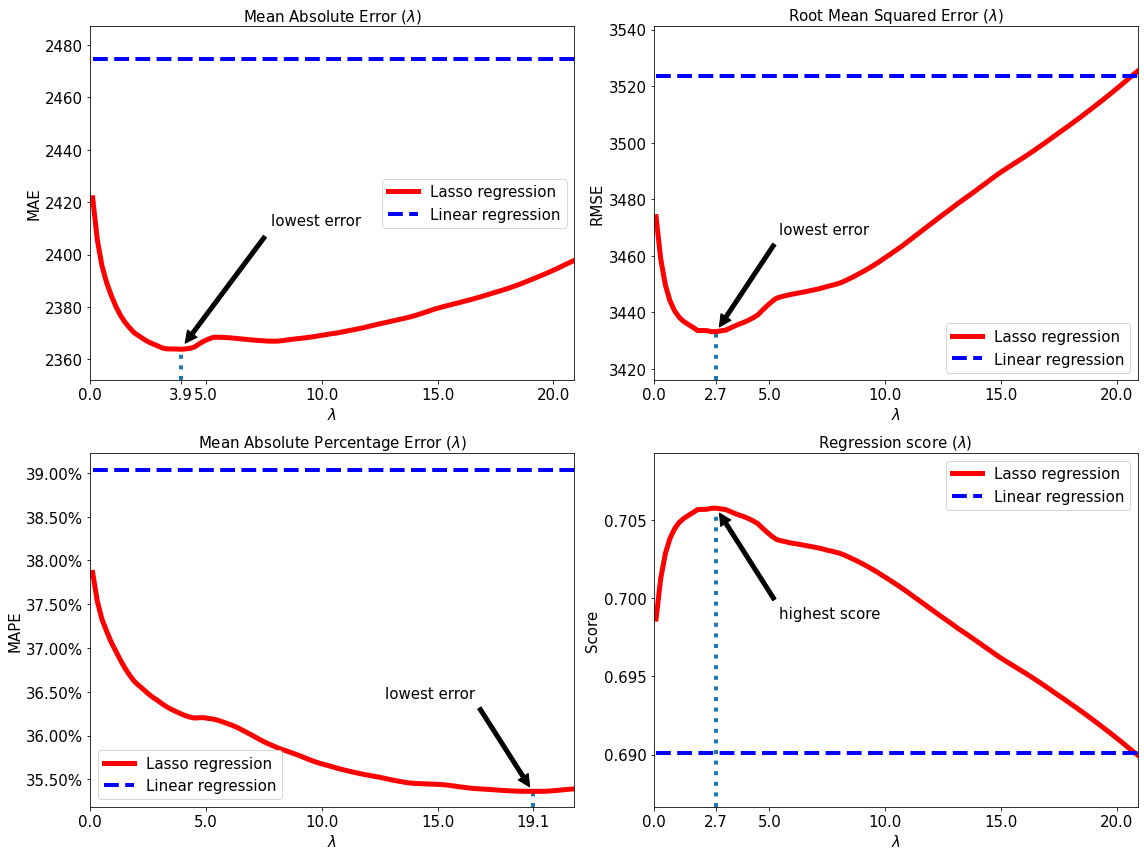

In [90]:
comparison


<br>

Next plot presents lowest achieved values of the three aforementioned errors for both **linear and Lasso regression**. To assess the performance of created models, some **reference** is needed. For that reason, the errors have been calculated also for two hypothetical scenarios. In first one we simply guess the attendance with the **overall mean** derived from whole dataset. Second one, slightly more sophisticated, uses **club-specific means** for prediction. As shown, applying second method already provides significant improvement. However, Lasso regressiom performs even better. Considering the error I find most suitable for this project, that is **MAPE**, Lasso resulted in **over 17 pp. (~ 33%) reduction** of that error's value.
<br>
<br>

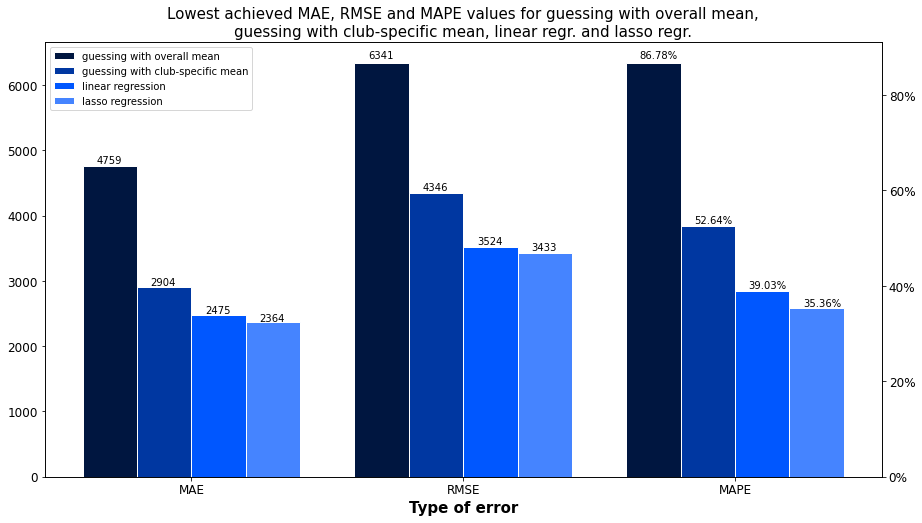

In [91]:
errors


<br>

When making use of **shrinkage methods**, that Lasso regression belongs to, it is worth to present the coefficient paths, i.e. how they get pushed more and more towards 0 with higher **$\lambda$** values. In this project, however, this type of plot is practically useless due to the **number of features - 139**. Therefore, we'll find a workaround.
<br>
<br>

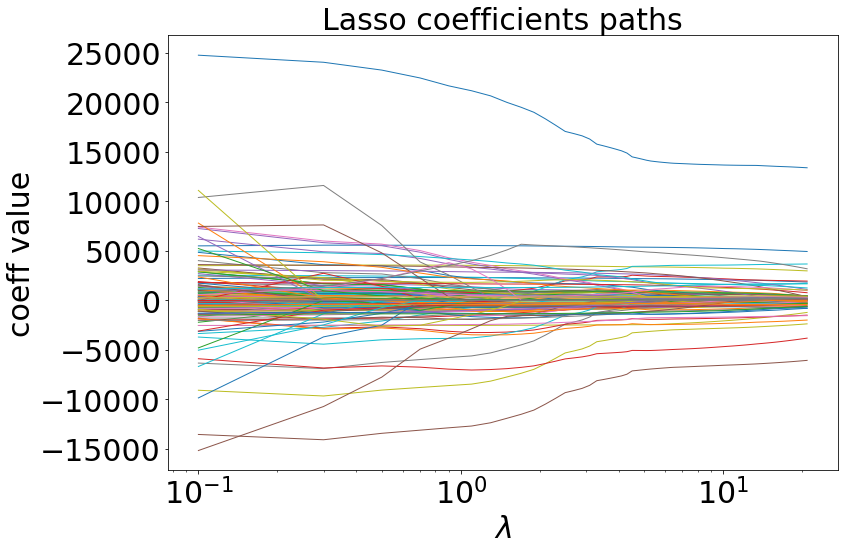

In [92]:
coeff_paths


<br>
Below, there is a series of plots showing most of the coefficients. For comparison purposes, their two values are presented, each coming from different model:

* the one that minimizes **RMSE** with $\lambda$ equal to **2.7**
* the one that minimizes **MAPE** with $\lambda$ equal to **19.1**

In result, we can observe how do coefficients behave, when increasing $\lambda$ from 2.7 to 19.1.

There are three clubs that strongly attract the audience, when they play as an away team. This fits in with the fact, that *Legia Warszawa*, *Lech Poznań* and *Wisła Kraków* are ones of the biggest and most popular polish football clubs. Playing against them is a big event for the majority of the rest of the league.

<br>

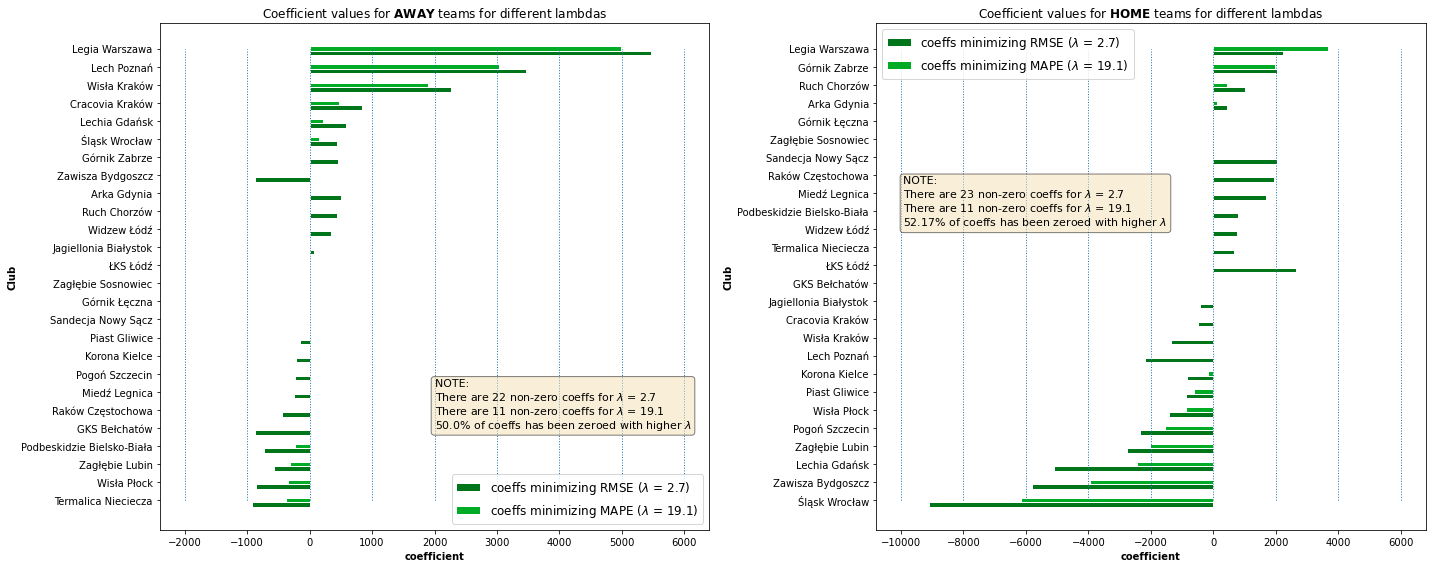

In [93]:
coeff_club


<br>

Next pair of plots presents the **date** related coeffcients. Spring seems to be a time during a year, when people are more prone to visiting stadiums. Not surprisingly, summer holidays' months have negative coefficients, as well as the winter months. 

Sunday is the day of the week, we should expect highest attendance on. Two other days of the weekend have also a positive impact, while working days - negative.
<br>

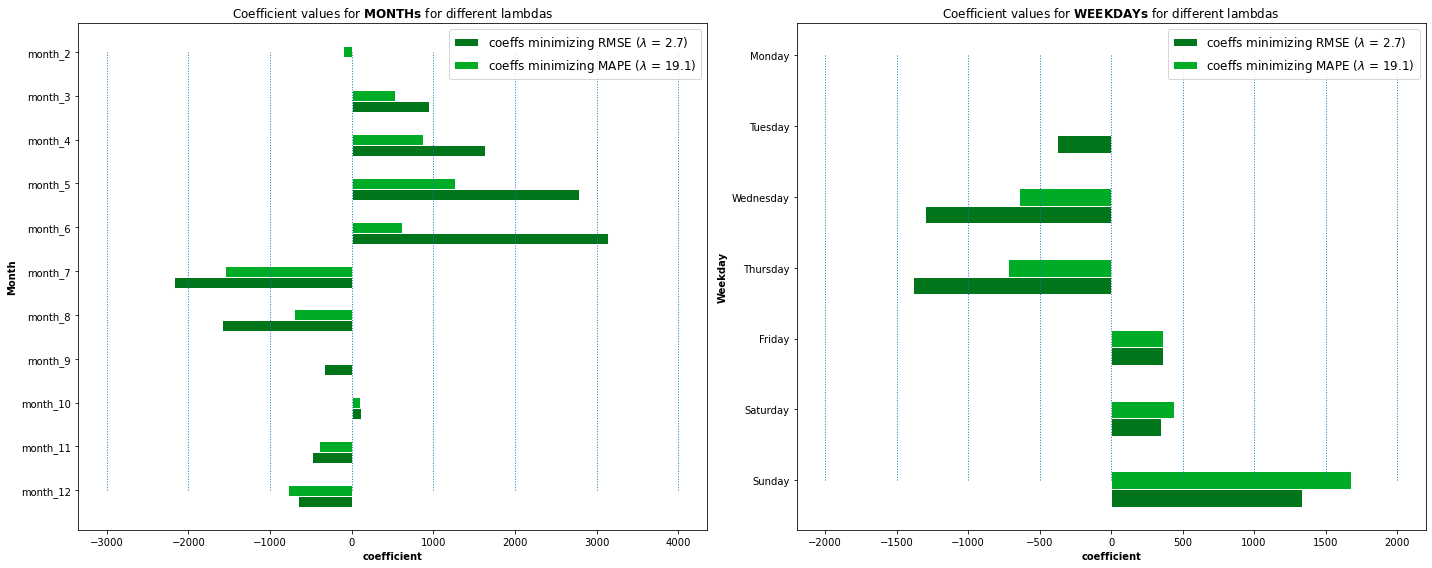

In [104]:
coeff_date


<br>

In terms of **weather**, the only highly relevant feature turns out to be average temperature during 12 hours prior to the match. The warmer - the better. To some extent, sky cloudcover lowers the number of attendees, while the precipitation has no influence at all.

Considering teams' past **performance** there are some strong incentives, that make more people attend the matches. The strongest one is the difference between goals scored and goals conceded during whole season. Highly important are the numbers of points gained in last 7 and 5 matches. Of lower influence are the features showing goals scored and the goal difference.
<br>

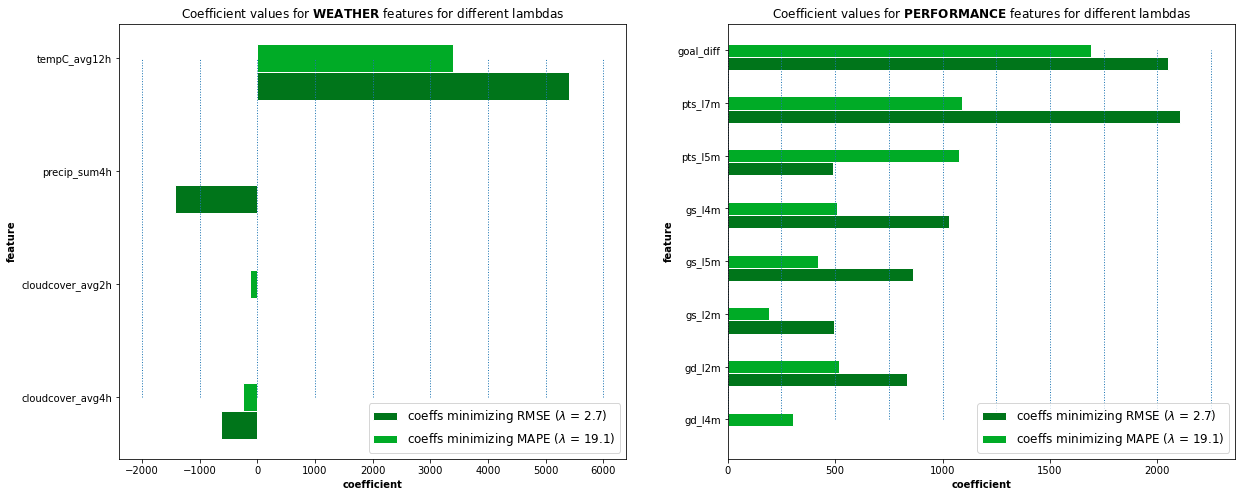

In [101]:
coeff_weather